
This code defines a function called osbm_graph, which generates directed graphs using the Overlapping Stochastic Block Model (OSBM), and several auxiliary functions to process and analyse the graphs. Below is the meaning of each input parameter:

Arguments to the osbm_graph function:
n (default value 100): the number of nodes in the graph to be generated. This determines the total number of nodes in the graph.

alphaVect (default value [1/3, 1/3, 1/3]): community preference vector. Each element represents the probability that a node belongs to the corresponding community. The length of the vector determines the number of communities.

lambda_ (default value 4): strength of intra-community connections. It affects the density of edges between nodes in the same community. Higher values mean that nodes within a community are more likely to be connected to each other.

epsilon (default 1): strength of inter-community connections. It affects the probability of nodes connecting between different communities. A lower value means that nodes in different communities are less likely to connect to each other.

bias (default -5.5): Used to adjust the connection preference of nodes from overlapping communities. It directly affects the behaviour of nodes with multiple community memberships.


In [18]:
import numpy as np
import scipy.stats as stats
import networkx as nx

def osbm_graph(n=100, alphaVect=[1/3, 1/3, 1/3], lambda_=3, epsilon=1, bias=-5.5):
    Q = len(alphaVect)
    Qov = Q + 1
    Z = np.ones((n, Qov))
    W = epsilon * np.ones((Qov, Qov))
    W[:Q, :Q] = -epsilon
    np.fill_diagonal(W, lambda_)
    W[Qov-1, Qov-1] = bias
    nbEmpty = 0
    nbSingle = 0
    nbOverlaps = 0
    
    for q in range(Q):
        Z[:, q] = stats.bernoulli.rvs(alphaVect[q], size=n)
    
    g = nx.DiGraph()
    for i in range(n):
        if sum(Z[i, :-1]) == 0:
            nbEmpty += 1
        elif sum(Z[i, :-1]) == 1:
            nbSingle += 1
        else:
            nbOverlaps += 1
            
        for j in range(n):
            if i != j:
                p = stats.logistic.cdf(np.dot(np.dot(Z[i, :], W), Z[j, :]))
                if stats.bernoulli.rvs(p):
                    g.add_edge(i, j)
    
    print("Total number of vertices:", n)
    print("Number of unclassified vertices:", nbEmpty)
    print("Number of overlaps:", nbOverlaps)
    print("Others:", nbSingle)

    return {'Z': Z[:, :Q], 'graph': g}

def encode_partition(p):
    N = len(p)
    Q = len(np.unique(p))
    Z = np.zeros((N, Q))
    for q in range(Q):
        Z[p == q, q] = 1
    return Z

def euclidean_dist(x, y):
    return np.dot(x - y, x - y)

def get_connected_nodes(x):
    if x.shape[0] == x.shape[1]:
        nbrNodes = x.shape[0]
        not_connected = np.where((np.sum(x, axis=0) + np.sum(x, axis=1)) == 0)[0]
        connected_nodes = np.setdiff1d(np.arange(nbrNodes), not_connected)
    return connected_nodes

def getModel_osbm(object, **kwargs):
    if not isinstance(object, dict) or 'Z' not in object or 'graph' not in object:
        raise ValueError("Not a osbm object")
    
    q = kwargs.get('q', None)
    
    # Placeholder for additional logic related to 'q'
    
    res = {'q': q, 'Z': object['Z']}
    return res

def edges_to_adj_mat(x, symmetrize=False, n=None):
    if n is None:
        n = np.max(x)
    mat = np.zeros((n, n))
    mat[x[0, :], x[1, :]] = 1
    if symmetrize:
        mat[x[1, :], x[0, :]] = 1
    return mat

def adj_mat_to_edges(x, directed=False):
    if x.shape[0] == x.shape[1]:
        nbrNodes = x.shape[0]
        not_connected = np.where((np.sum(x, axis=0) + np.sum(x, axis=1)) == 0)[0]
        if len(not_connected) > 0:
            x = np.delete(np.delete(x, not_connected, axis=0), not_connected, axis=1)
            print("Some nodes are not connected to the network")
        if directed:
            m = np.transpose(np.where(np.transpose(x) == 1))
        else:
            m = np.transpose(np.where(np.triu(x) == 1))
    return m


In [19]:
# Generate graph g
result = osbm_graph()
g = result['graph']  # 从结果中提取图结构

# View Diagram Information
print("Number of edges:", g.number_of_edges())

Total number of vertices: 100
Number of unclassified vertices: 28
Number of overlaps: 25
Others: 47
Number of edges: 1293


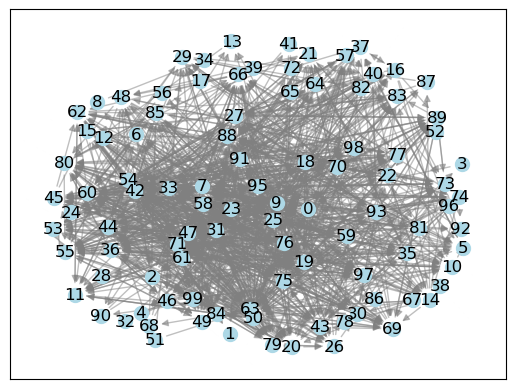

In [20]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(g, k=1, iterations=20)  # 可以通过调整k的值来增加节点间的距离

# 绘制节点和边
nx.draw_networkx_nodes(g, pos, node_size=100, node_color='lightblue')  # 减小节点大小
nx.draw_networkx_edges(g, pos, width=1, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(g, pos)

# 显示图形
plt.show()

In [21]:
import numpy as np

Z = result['Z']

# 初始化表格
Q = 3 # 社区的数量
table = np.zeros((Q, Q), dtype=object)

# 填充表格
for i in range(Q):
    for j in range(Q):
        if i == j:
            # 只属于这一社区的点的数量
            single_count = np.sum(Z[:, i] * (np.sum(Z, axis=1) == 1))
            table[i, j] = str(single_count)
        else:
            # 重叠的数量
            overlap_count = np.sum(Z[:, i] * Z[:, j])
            table[i, j] = '+' + str(overlap_count)

# 打印表格
print(table)


[['18.0' '+9.0' '+11.0']
 ['+9.0' '13.0' '+9.0']
 ['+11.0' '+9.0' '16.0']]


In [ ]:
import numpy as np

def initialize_parameters(N, q):
    eta0 = np.ones(q) / 2
    zeta0 = np.ones(q) / 2
    eta = eta0.copy()
    zeta = zeta0.copy()
    an = 1
    bn = 1
    S = np.zeros((q, q))
    vecW = np.random.randn(q**2)
    xi = np.full((N, N), 0.001)
    np.fill_diagonal(xi, 0)

    return eta, zeta, an, bn, S, vecW, xi

def osbm_algorithm(X, qmin=2, qmax=None, nbiter=50, fpnbiter=5, nstart=1, init=None):
    # Initialize parameters
    N = X.shape[0]
    if qmax is None:
        qmax = qmin

    y = [None] * (qmax - qmin + 1)
    youter = [None] * nstart
    criterion = np.zeros((nstart, qmax - qmin + 1))

    for run in range(1, nstart + 1):
        # Initialize some variables for the current run

        for q in range(qmin, qmax + 1):
            # Initialize parameters for the current q
            eta, zeta, an, bn, S, vecW, xi = initialize_parameters(N, q)

            for _ in range(nbiter):
                # Perform iterations for the current q

                # Update parameters here
                # You will need to implement the update logic based on your specific OSBM algorithm

            # Store the results for the current q
            yinner = {
                'W': vecW,
                'S': S,
                'alpha': eta / (eta + zeta),
                'Tau': tau,
                'Xi': xi,
                'an': an,
                'bn': bn,
                'l': l,
                'eta': eta,
                'zeta': zeta,
                'criterion': max(l)
            }
            y[q - qmin] = yinner
            criterion[run - 1, q - qmin] = yinner['criterion']

        youter[run - 1] = yinner

    # Choose the best result based on criterion
    i_opt = np.argmax(criterion, axis=1)
    i_res = 0
    result = {
        'method': 'variational bayes',
        'nnodes': N,
        'qmin': qmin,
        'qmax': qmax,
        'output': youter,
        'directed': True
    }

    return result

# Example usage
# X is your input data
result = osbm_algorithm(X)


In [ ]:
import numpy as np

# Extract the optimized_W from the result
optimized_W_list = [y['W'] for y in result['output']]

# Assuming you have the optimized_W_list and other necessary variables
# Compute community probabilities for each node
def compute_community_probabilities(W):
    # Implement a method to compute community probabilities based on W
    # For example, you can apply a softmax function to the rows of W
    community_probabilities = np.exp(W) / np.sum(np.exp(W), axis=1, keepdims=True)
    return community_probabilities

# Generate Z_i for each node
def generate_Zi(W_list):
    Z_i_list = []
    for W in W_list:
        community_probabilities = compute_community_probabilities(W)
        num_nodes = len(W)
        num_communities = len(W[0])  # Assuming W has the shape (num_nodes, num_communities)
        Z_i = []
        for i in range(num_nodes):
            community_assignment = np.random.choice(num_communities, p=community_probabilities[i])
            Zi = np.zeros(num_communities)
            Zi[community_assignment] = 1
            Z_i.append(Zi)
        Z_i_list.append(Z_i)
    return Z_i_list

# Generate Z_i for each node using the optimized_W_list
Z_i_list = generate_Zi(optimized_W_list)

# Z_i_list is a list of lists of numpy arrays, where each inner list represents the community assignment for each community size
# You can access Z_i_list[i][j] to get the community assignment for node i under community size j
